# 06. Double-spectra detection using the CNN

The script aims to identify double-spectra in the data using the trained models, namely the <mark>Fully-Connected Neural Network</mark> (script 04; NN1) and the <mark>Convolutional Neural Network</mark> (script 05; CNN).

1. **Load data files and define input parameters**
2. **Generate confidence values for all classified spectra **
3. **Plotting the confidence value distributions**

**Data**: 02nd Dec 2019<br>
**Author**: Soumya Shreeram<br>
**Guidance from**: Anand Raichoor, Schäfer Christoph E. Rerné<br>
**Script adapted from**: S. Ben Nejma

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

import numpy as np
from numpy.lib.format import open_memmap

import pickle
import keras
from keras.models import load_model

## 1. Load data files and define input parameters

In [5]:
def loadFile(filename):
    return np.load('Data_files/'+filename+'.npy', mmap_mode='r')

In [6]:
model_path = 'Algos/NN_folder/'
no_classes = 3
no_fibres = 10048

# loading previously generated data
wavelength = loadFile('wavelength')
X = loadFile('X_corrupted')
Y = loadFile('Y_corrupted')
infos = loadFile('info')

## 2. Generate confidence values for all classified spectra 

The spectra are classified for 3 catergoriers: quasars, galaxies, and other types. The CNN model is trained to classify these categories in the spectra. The classification is quantified by the confidence value that is a value generated for every category per spectra. The following code generates these confidence values in the array `confidences_CNN`.

In [7]:
def generateCondidenceValues(model_path, model_name, X):
    """
    Function to calculate the confidence values for each galaxy type in the data
    @model_path :: path to the directory where the neural network models are saved
    @model_name :: name of the model to be used for classification
    @X :: data array contained the fluxes of the spectra
    
    Return @probabilitis :: sorted confidences for by magnitude (not class label)
    """
    # loading the model
    model = load_model(model_path+model_name+'.h5')
    
    # reshaping and normalizing the X array
    data = X.reshape(X.shape[0], X.shape[1], 1)
    data = keras.utils.normalize(data, axis=1)
    
    # get results from model and convert to probabilities
    results = model.predict(data)
    confidences = np.exp(results)/np.sum(np.exp(results), axis=1, keepdims=True)
    return np.sort(confidences)

In [ ]:
confidences_CNN = generateCondidenceValues(model_path, 'CNN', X)

## 3. Plotting the confidence value distributions

In [77]:
def setLabels(ax, xlabel, ylabel, ticks):
    """
    Function sets the axes labels, legent size, and ticks
    """
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.grid()
    if ticks:
        ax.tick_params(which='both', labelsize=18)
    return

def calDiffinConfidenceVals(confidences_CNN):
    """
    Calculate the difference in the confidence values between the 3 catergories
    @confidences_CNN :: 2D array with the confidence values for the 3 catergories
    @Returns dif_arr :: 2D array with the differences
    """
    diff12 = confidences_CNN[:,-1]-confidences_CNN[:,-2]
    diff23 = confidences_CNN[:,-2]-confidences_CNN[:,-3]
    diff31 = confidences_CNN[:,-1]-confidences_CNN[:,-3]
    diff_arr = [diff12, diff23, diff31]
    return diff_arr

def plotDiffConfidenceVals(confidences_CNN, ax, plot_diffs):
    """
    Function plots the difference in confidence values between the 3 categories
    @confidences_CNN :: array with the confidence values for the 3 categories
    @plot_diffs :: array with values catergories between which the differences are taken
    """
    diff_arr = calDiffinConfidenceVals(confidences_CNN)
    colors = ['#2a0fdb', '#0fdb0f','#c71508' ]
    labels = [r'${C_1 - C_2}$', r'${C_1 - C_3}$', r'${C_2 - C_3}$']
    fibres = np.arange(len(confidences_CNN))
    
    if plot_diffs==[1]:
        idx = plot_diffs[0]
        ax.plot(fibres, diff_arr[idx], colors[idx+1], label=labels[idx+1])
        setLabels(ax, 'Spectras/Fibres \n (sorted by confidence)', '', True)
    else:    
        for i,idx in enumerate(plot_diffs):
            ax.plot(fibres, diff_arr[idx], colors[i], label=labels[i])
            setLabels(ax, 'Spectras/Fibres \n (sorted by confidence)', r'$\Delta$'+'Confidence\n values', True)
    return
    

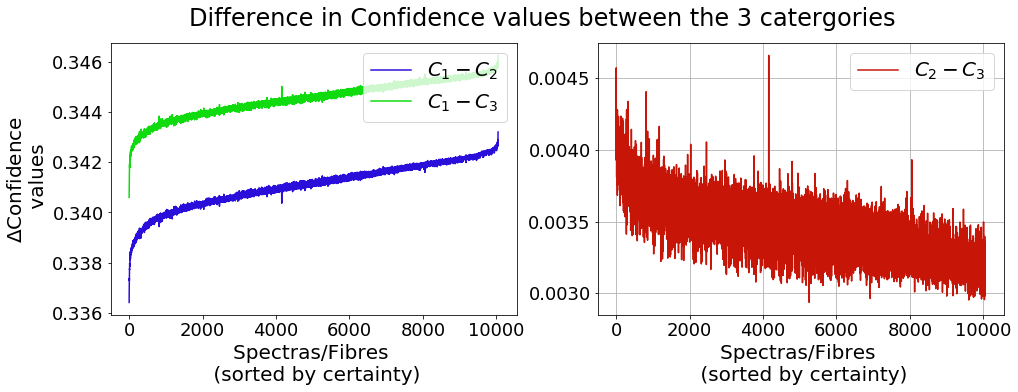

In [78]:
# sorts the confidence value indicies in the ascending order and updates all arrays
ascending_idx = np.argsort(confidences_CNN[:,-1])
confidences_CNN = confidences_CNN[ascending_idx]
infos = infos[ascending_idx]

# plots the differences in the confidence values between the categeries
fig, ax = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Difference in Confidence values between the 3 catergories')

plotDiffConfidenceVals(confidences_CNN, ax[0], plot_diffs=[0,2])
plotDiffConfidenceVals(confidences_CNN, ax[1], plot_diffs=[1])

The following plot aims to understand the confidance value distribution for the 3 categories by magnitude. For every spectra, the category with the highest confidence value is plotted to the right as the **Dominant categoty** and the distribution of the confidence values for the remaining two **sub-dominant**(low confidence values) categoeries are plotted to the right.

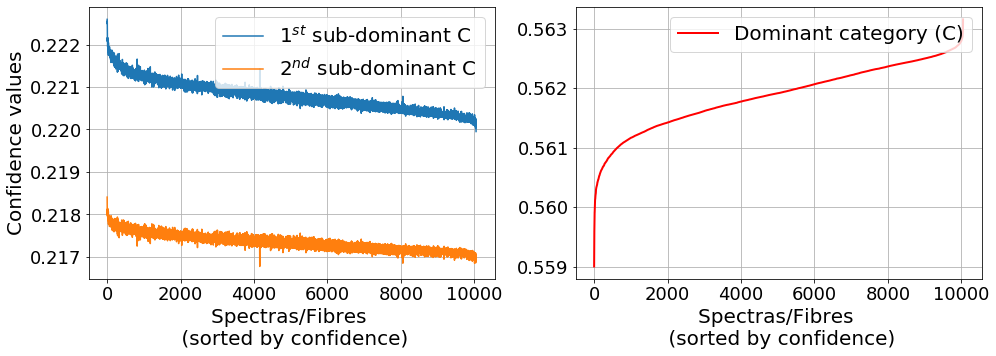

In [86]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
fibres = np.arange(len(confidences_CNN))
labels = ['Dominant category (C)', r'$1^{st}$ sub-dominant C', r'$2^{nd}$ sub-dominant C']

# left plot, sub-dominant categories (C)
for i in [1, 2]:
    ax[0].plot(confidences_CNN[:,::-1][:,i], label=labels[i])
setLabels(ax[0], 'Spectras/Fibres \n (sorted by confidence)', 'Confidence values', ticks=True)    

# right plot, dominant category (C)
ax[1].plot(confidences_CNN[:,::-1][:,0], 'r', lw=2, label=labels[0])
setLabels(ax[1], 'Spectras/Fibres \n (sorted by confidence)', '', ticks=True)    